<a href="https://colab.research.google.com/github/fakelaboratory/backup/blob/main/Boiling_water_simulation%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Algorithm, transformation cycle of molecule(group):**
1.   if molecule temperature > 100,
then check neighbors, if near exist gas then connect, else randomly can transform to gas(change state and remove from the common array). if connected to someone - register the new transformation group and try to reorginize to a big cube shape
2.   check registered groups the archimed force(*1), if the archimed force more than pressure of water then this group now in the transportation state(moving up)
3.   check groups which in the transportation state: if not on the surface then move up, else(on surface) check can be free or not(*2). can be free if pressure inside the group more than surface tension force. if near other groups - connect(merge)

**Algorithm for all molecules(water):**
*   Fill holes(shift down if bottom now the gas and not in the common array)
*   Try to make the water surface flat<br><br>
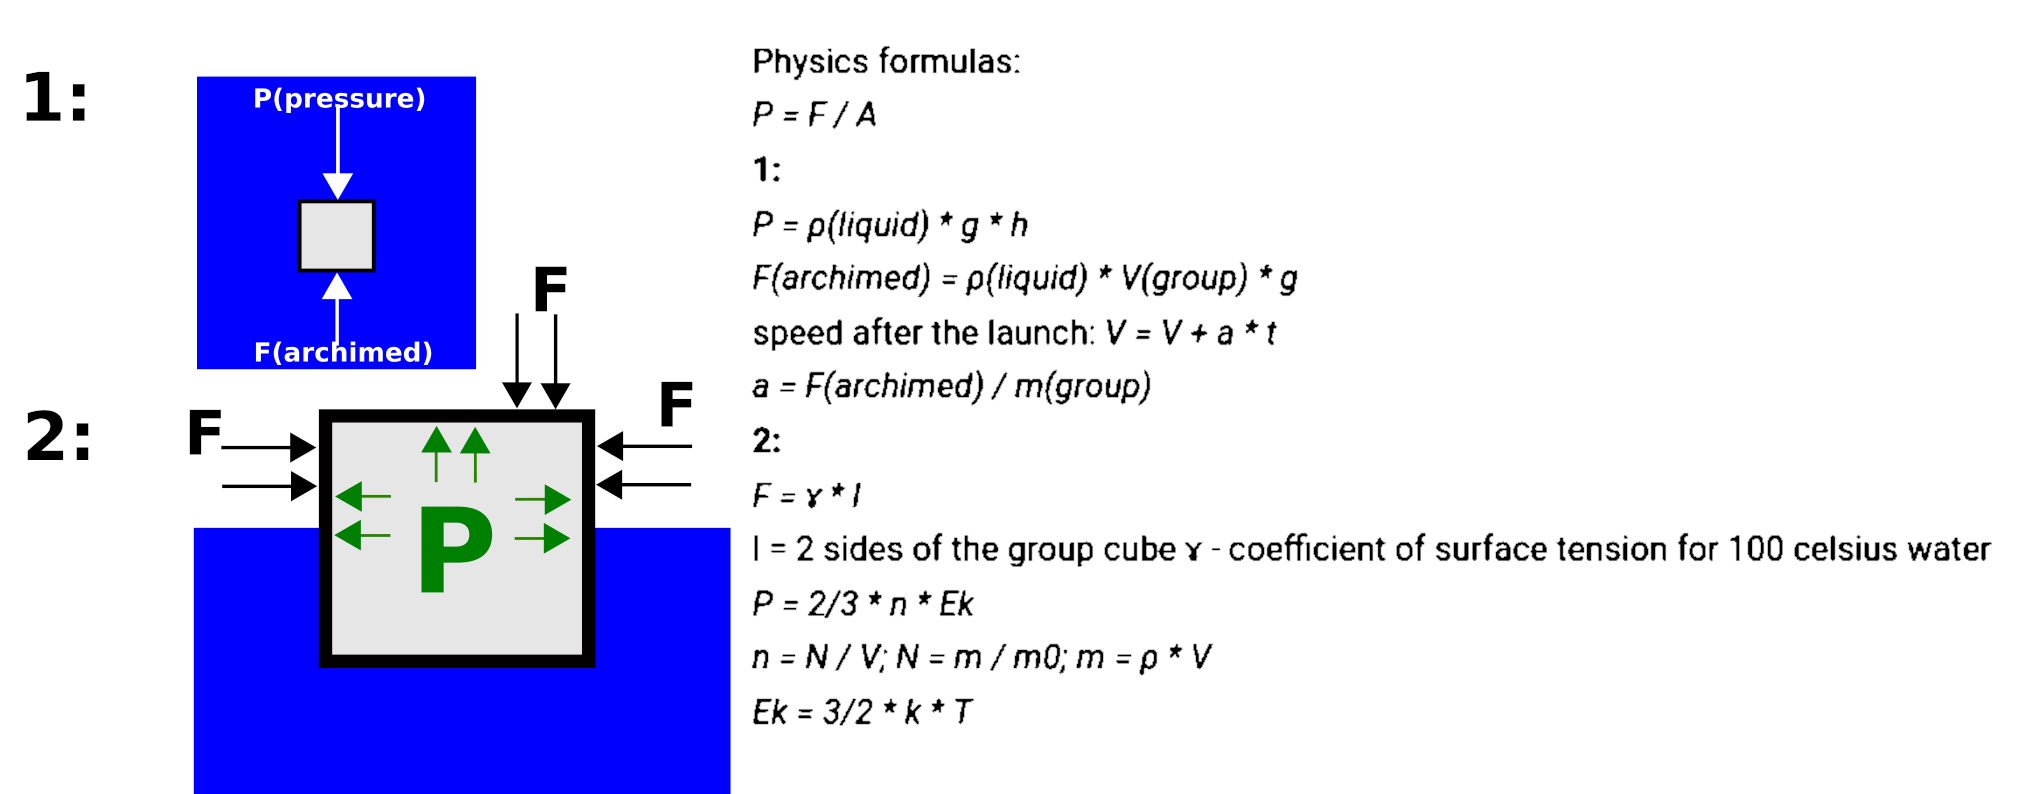

In [48]:
!pip install moderngl
!pip install pyrr
!pip install moviepy
import moderngl as gl
import numpy as np
import pyrr as pyrr
from PIL import Image
import moviepy.editor as mpy
from google.colab import files

ctx = gl.create_context(standalone=True, backend='egl')
print(ctx.info)

{'GL_VENDOR': 'Mesa', 'GL_RENDERER': 'llvmpipe (LLVM 15.0.7, 256 bits)', 'GL_VERSION': '4.5 (Core Profile) Mesa 23.0.4-0ubuntu1~22.04.1', 'GL_POINT_SIZE_RANGE': (1.0, 255.0), 'GL_SMOOTH_LINE_WIDTH_RANGE': (1.0, 255.0), 'GL_ALIASED_LINE_WIDTH_RANGE': (1.0, 255.0), 'GL_POINT_FADE_THRESHOLD_SIZE': 1.0, 'GL_POINT_SIZE_GRANULARITY': 0.10000000149011612, 'GL_SMOOTH_LINE_WIDTH_GRANULARITY': 0.10000000149011612, 'GL_MIN_PROGRAM_TEXEL_OFFSET': -32.0, 'GL_MAX_PROGRAM_TEXEL_OFFSET': 31.0, 'GL_MINOR_VERSION': 5, 'GL_MAJOR_VERSION': 4, 'GL_SAMPLE_BUFFERS': 0, 'GL_SUBPIXEL_BITS': 8, 'GL_CONTEXT_PROFILE_MASK': 1, 'GL_UNIFORM_BUFFER_OFFSET_ALIGNMENT': 16, 'GL_DOUBLEBUFFER': False, 'GL_STEREO': False, 'GL_MAX_VIEWPORT_DIMS': (16384, 16384), 'GL_MAX_3D_TEXTURE_SIZE': 2048, 'GL_MAX_ARRAY_TEXTURE_LAYERS': 2048, 'GL_MAX_CLIP_DISTANCES': 8, 'GL_MAX_COLOR_ATTACHMENTS': 8, 'GL_MAX_COLOR_TEXTURE_SAMPLES': 4, 'GL_MAX_COMBINED_FRAGMENT_UNIFORM_COMPONENTS': 262144, 'GL_MAX_COMBINED_GEOMETRY_UNIFORM_COMPONENTS': 2

In [73]:
ctx.enable(gl.BLEND)
prog = ctx.program(
    vertex_shader="""
        #version 330
        in vec4 in_vert;
        void main() {
            gl_Position = in_vert;
        }
    """,
    fragment_shader="""
        #version 330
        uniform vec4 u_color;
        out vec4 f_color;
        void main() {
            f_color = u_color;
        }
    """,
)
vertices = np.asarray([
    [-0.5 , -0.5 , -0.5, 1.0] ,
    [ 0.5 , -0.5 , -0.5, 1.0] ,
    [ 0.5 ,  0.5 , -0.5, 1.0] ,
    [ 0.5 ,  0.5 , -0.5, 1.0] ,
    [-0.5 ,  0.5 , -0.5, 1.0] ,
    [-0.5 , -0.5 , -0.5, 1.0] ,

    [-0.5 , -0.5 ,  0.5, 1.0] ,
    [ 0.5 , -0.5 ,  0.5, 1.0] ,
    [ 0.5 ,  0.5 ,  0.5, 1.0] ,
    [ 0.5 ,  0.5 ,  0.5, 1.0] ,
    [-0.5 ,  0.5 ,  0.5, 1.0] ,
    [-0.5 , -0.5 ,  0.5, 1.0] ,

    [-0.5 ,  0.5 ,  0.5, 1.0] ,
    [-0.5 ,  0.5 , -0.5, 1.0] ,
    [-0.5 , -0.5 , -0.5, 1.0] ,
    [-0.5 , -0.5 , -0.5, 1.0] ,
    [-0.5 , -0.5 ,  0.5, 1.0] ,
    [-0.5 ,  0.5 ,  0.5, 1.0] ,

    [ 0.5 ,  0.5 ,  0.5, 1.0] ,
    [ 0.5 ,  0.5 , -0.5, 1.0] ,
    [ 0.5 , -0.5 , -0.5, 1.0] ,
    [ 0.5 , -0.5 , -0.5, 1.0] ,
    [ 0.5 , -0.5 ,  0.5, 1.0] ,
    [ 0.5 ,  0.5 ,  0.5, 1.0] ,

    [-0.5 , -0.5 , -0.5, 1.0] ,
    [ 0.5 , -0.5 , -0.5, 1.0] ,
    [ 0.5 , -0.5 ,  0.5, 1.0] ,
    [ 0.5 , -0.5 ,  0.5, 1.0] ,
    [-0.5 , -0.5 ,  0.5, 1.0] ,
    [-0.5 , -0.5 , -0.5, 1.0] ,

    [-0.5 ,  0.5 , -0.5, 1.0] ,
    [ 0.5 ,  0.5 , -0.5, 1.0] ,
    [ 0.5 ,  0.5 ,  0.5, 1.0] ,
    [ 0.5 ,  0.5 ,  0.5, 1.0] ,
    [-0.5 ,  0.5 ,  0.5, 1.0] ,
    [-0.5 ,  0.5 , -0.5, 1.0]
],dtype='f4')

def transform(v,type,args):
  if(type=="rotation"):
    mat = pyrr.matrix44.create_from_axis_rotation([args[0],args[1],args[2]],args[3])
  if(type=="scale"):
    mat = pyrr.matrix44.create_from_scale([args[0],args[1],args[2]])
  if(type=="translation"):
    mat = pyrr.matrix44.create_from_translation([args[0],args[1],args[2]])
  #mat = pyrr.matrix33.create_from_matrix44(mat)
  for i in range(len(v)):
    v[i]= pyrr.matrix44.apply_to_vector(mat, v[i])

In [16]:
#class molecule
  #[vertices]
  #[middle point]
  #size
  #state (water,gas)
#obj water
  #molecules
  #middle point
#obj plate
  #position
#obj heat
  #position
  #temperature

In [79]:
def render_frame(time):
  #rotate cube
  v1 = np.copy(vertices) #vertices for render
  transform(v1,"scale"   ,[0.2,0.2,0.2])
  transform(v1,"rotation",[1.0,1.0,0.0,0.25])
  transform(v1,"translation",[-0.5,0.0,0.0])

  v2 = np.copy(vertices) #vertices for render
  transform(v2,"scale"   ,[0.2,0.2,0.2])
  transform(v2,"rotation",[1.0,1.0,0.0,0.25])
  transform(v2,"translation",[0.5,0.0,0.0])


  fbo = ctx.framebuffer(
    color_attachments=[ctx.texture((512, 512), 3)]
  )
  fbo.use()
  fbo.clear(0.0+time, 0.0+time, 0.0+time, 1.0)

  #prepare buffers and draw
  vbo = ctx.buffer(v1.reshape(v1.size).tobytes())
  vao = ctx.vertex_array(prog, vbo, "in_vert")
  u_color = prog["u_color"]
  u_color.value = [1.0,0.0,1.0,0.2]

  vao.render()

  vbo = ctx.buffer(v2.reshape(v2.size).tobytes())
  vao = ctx.vertex_array(prog, vbo, "in_vert")
  u_color = prog["u_color"]
  u_color.value = [0.0,1.0,0.0,0.2]

  vao.render()


  return np.array(Image.frombytes(
    "RGB", fbo.size, fbo.color_attachments[0].read(),
    "raw", "RGB", 0, -1
  ))

clip = mpy.VideoClip(render_frame, duration=2) # 2 seconds
clip.write_gif("anim.gif",fps=15)
#now in files anim.gif

MoviePy - Building file anim.gif with imageio.
